In [1]:
import tstrippy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import numpy as np
import matplotlib.pyplot as plt

## How to test the bar? 

## Load the units

In [2]:
unitbasis = tstrippy.Parsers.potential_parameters.unitbasis
unitT=u.Unit(unitbasis['time'])
unitV=u.Unit(unitbasis['velocity'])
unitD=u.Unit(unitbasis['distance'])
unitM=u.Unit(unitbasis['mass'])
unitG=u.Unit(unitbasis['G'])
G = const.G.to(unitG).value

## Load Galactic Parameters

In [3]:
MWparams = tstrippy.Parsers.potential_parameters.pouliasis2017pii()
MWrefframe= tstrippy.Parsers.potential_parameters.MWreferenceframe()

## Add the bar parameters

In [4]:
Mbar = 990.0*2.32*1e7 * unitM

In [5]:
# mass and size
abar = 4 * unitD
bbar = 1 * unitD
cbar = 0.5 * unitD
Mbar = 990.0*2.32*1e7 * unitM
barparams = [MWparams[0],Mbar.value,abar.value,bbar.value,cbar.value]
# oreitnation and bar pattern speed
theta0= 25 * (np.pi/180) 
omega =  28  * 2*np.pi * unitV / unitD
omega = -omega.value
barpolycoeff=[theta0,omega]

## Reduce the mass of the disks
we are allocating it to the bar

In [6]:
MWparams[5] = 1120.0 * 2.32*10**7 
MWparams[8] = 1190.0 * 2.32*10**7 

## Set integration time

Do this in years so that you can assure the number of timesteps is an integer, and then convert the total time *T* and the timestep *dt* into integration units.

In [7]:
# make the timesteps go backward!
integrationTime = 5e9
timestep = 1e5
# change the sign because we are going backward in time 
T,dt = integrationTime, timestep
Ntimestep=int(T/dt)
T,dt=T*u.yr,dt*u.yr
T,dt=T.to(unitT),dt.to(unitT)

## Load the Globular Clusters
Store them in an astropy object to store them to galactocentric coordinates

In [8]:
GCdata  =   tstrippy.Parsers.baumgardtMWGCs().data
skycoordinates=coord.SkyCoord(
    ra=GCdata['RA'],
    dec=GCdata['DEC'],
    distance=GCdata['Rsun'],
    pm_ra_cosdec=GCdata['mualpha'],
    pm_dec=GCdata['mu_delta'],
    radial_velocity=GCdata['RV'],)
galacticcoordinates = skycoordinates.transform_to(MWrefframe)
x,y,z=galacticcoordinates.cartesian.xyz.to(unitD).value
vx,vy,vz=galacticcoordinates.velocity.d_xyz.to(unitV).value
# SEND THEM BACKWARD 
vx,vy,vz=-vx,-vy,-vz
# grab the number of objects
Nobj=len(x)

## Initialize the integrator

In [9]:
tstrippy.integrator.setstaticgalaxy("pouliasis2017pii",MWparams)
tstrippy.integrator.setinitialkinematics(x,y,z,vx,vy,vz)
tstrippy.integrator.setintegrationparameters(T.value,dt.value,Ntimestep)
tstrippy.integrator.initgalacticbar("longmuralibar",barparams,barpolycoeff)
xt,yt,zt,vxt,vyt,vzt=tstrippy.integrator.leapfrogintime(Ntimestep,Nobj)
tstrippy.integrator.deallocate()

## Analyize the change in energy

In [10]:
E0 = np.zeros(Nobj)
_,_,_,phi0=tstrippy.potentials.pouliasis2017pii(MWparams,xt[:,0],yt[:,0],zt[:,0])
_,_,_,phiF=tstrippy.potentials.pouliasis2017pii(MWparams,xt[:,-1],yt[:,-1],zt[:,-1])
T0 = 0.5*(vxt[:,0]**2+vyt[:,0]**2+vzt[:,0]**2)
TF = 0.5*(vxt[:,-1]**2+vyt[:,-1]**2+vzt[:,-1]**2)

E0 = T0 + phi0
EF = TF + phiF
Lz0 = xt[:,0]*vyt[:,0]-yt[:,0]*vxt[:,0]
LzF = xt[:,-1]*vyt[:,-1]-yt[:,-1]*vxt[:,-1]

In [11]:
import matplotlib
colors = matplotlib.cm.rainbow(np.linspace(0,1,Nobj))

# make the font size bigger and also us Latex font
plt.rc('text', usetex=True)
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)


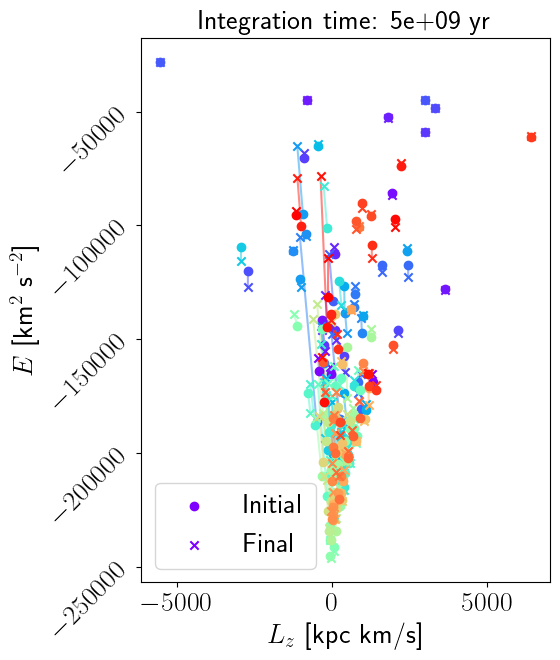

In [12]:
fig,axis=plt.subplots(1,1,figsize=(6,7))
AXIS = {
    "xlabel": r"$L_z$ [kpc km/s]",
    "ylabel": r"$E$ [km$^{2}$ s$^{-2}$]",
    "title": "Integration time: {:.0e} yr".format(integrationTime),
}
for i in range(Nobj):
    if i ==0:
        axis.scatter(Lz0[i],E0[i],color=colors[i],label="Initial")
        axis.scatter(LzF[i],EF[i],color=colors[i],marker='x',label="Final")
    else:
        axis.scatter(Lz0[i],E0[i],color=colors[i])
        axis.scatter(LzF[i],EF[i],color=colors[i],marker='x')
    axis.plot([Lz0[i],LzF[i]],[E0[i],EF[i]],color=colors[i],alpha=0.5,zorder=0)
axis.set(**AXIS)
axis.tick_params(axis='y', rotation=45)
axis.legend()
fig.tight_layout()  

# Now add a stream to go forward

In [13]:
targetCluster = "NGC5139"
clusterIndex=np.where(GCdata['Cluster'] == targetCluster)[0][0]

make plummer sphere

In [14]:
Mass = GCdata['Mass'][clusterIndex] 
halfMassRadius = GCdata['rh_m'][clusterIndex]
bPlummer = tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(halfmassradius=halfMassRadius)
NP = int(1e3)

In [15]:
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G,halfMassRadius.value,bPlummer.value,NP)

Extract host cluster

In [16]:
xH,yH,zH,vxH,vyH,vzH=xt[clusterIndex],yt[clusterIndex],zt[clusterIndex],vxt[clusterIndex],vyt[clusterIndex],vzt[clusterIndex]

flip the orbit and change sign of the velocities

In [17]:
xH,yH,zH=np.flip(xH),np.flip(yH),np.flip(zH)
vxH,vyH,vzH=-np.flip(vxH),-np.flip(vyH),-np.flip(vzH)

create a time array

In [18]:
tH = np.linspace(-T.value,0,Ntimestep+1)

reset the time integration parameters to go forward
- note that when integrating the cluster orbits, t0=0
- now, t0 will be extracted from the first element host orbit's time array tH

In [19]:
T = integrationTime
dt = timestep
Ntimestep=int(T/dt)
T,dt=T*u.yr,dt*u.yr
T,dt=T.to(unitT),dt.to(unitT)

## Initialize the integrator

In [20]:
tstrippy.integrator.setstaticgalaxy("pouliasis2017pii",MWparams)
tstrippy.integrator.setinitialkinematics(xp+xH[0],yp+yH[0],zp+zH[0],vxp+vxH[0],vyp+vyH[0],vzp+vzH[0])
tstrippy.integrator.setintegrationparameters(T.value,dt.value,Ntimestep)
tstrippy.integrator.inithostperturber(tH,xH,yH,zH,vxH,vyH,vzH,Mass.value,bPlummer.value)
tstrippy.integrator.initgalacticbar("longmuralibar",barparams,barpolycoeff)
tstrippy.integrator.leapfrogtofinalpositions()
xf=tstrippy.integrator.xf.copy()
yf=tstrippy.integrator.yf.copy()
zf=tstrippy.integrator.zf.copy()
vxf=tstrippy.integrator.vxf.copy()
vyf=tstrippy.integrator.vyf.copy()
vzf=tstrippy.integrator.vzf.copy()
tstrippy.integrator.deallocate()

# Look at the result

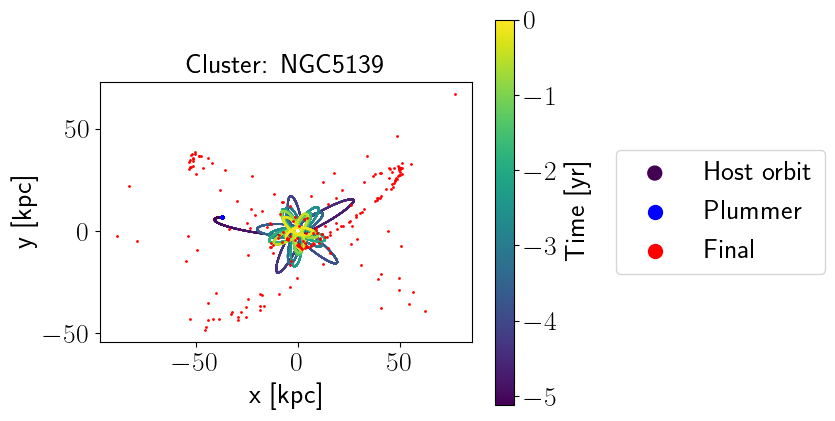

In [21]:
fig,axis=plt.subplots(1,1,figsize=(6,5))
im=axis.scatter(xH,yH,c=tH,cmap='viridis',s=0.1,label="Host orbit")
axis.scatter(xp+xH[0],yp+yH[0],color='blue',label="Plummer",s=4)
axis.scatter(xf,yf,color='red',label="Final",s=1)
fig.colorbar(im,ax=axis,label="Time [yr]")
axis.set_aspect("equal")
axis.set(xlabel="x [kpc]",ylabel="y [kpc]",title="Cluster: {}".format(targetCluster))
legend = axis.legend(loc='center left', bbox_to_anchor=(1.35, 0.5))
for handle in legend.legendHandles:
    handle.set_sizes([100])

## Check if orbit can be reproduced with the bar 

In [22]:
T = integrationTime
dt = timestep
Ntimestep=int(T/dt)
T,dt=T*u.yr,dt*u.yr
T,dt=T.to(unitT),dt.to(unitT)

In [23]:
tstrippy.integrator.setintegrationparameters(T.value,dt.value,Ntimestep)
tstrippy.integrator.setstaticgalaxy("pouliasis2017pii",MWparams)
tstrippy.integrator.setinitialkinematics(xH[0],yH[0],zH[0],vxH[0],vyH[0],vzH[0])
tstrippy.integrator.initgalacticbar("longmuralibar",barparams,barpolycoeff)
xCheck,yCheck,zCheck,vxCheck,vyCheck,vzCheck=tstrippy.integrator.leapfrogintime(Ntimestep,1)
tstrippy.integrator.deallocate()

In [24]:
def rotation_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

def rotate(x,y,theta):
    return np.dot(rotation_matrix(theta),np.array([x,y]))

bar_line = np.array([[-40,40],[0,0]])
bar_line = rotate(bar_line[0],bar_line[1],theta0)

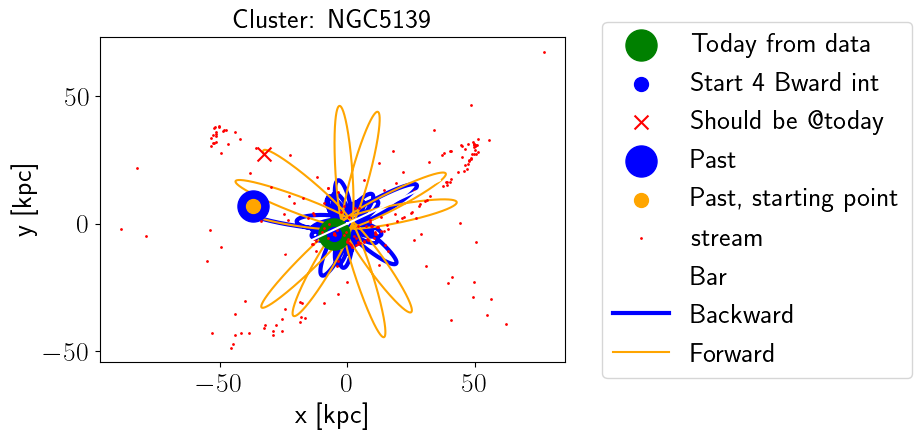

In [25]:
fig,axis=plt.subplots(1,1,figsize=(6,5))

## TODAY 
axis.scatter(x[clusterIndex],y[clusterIndex],c='g',s=500,label="Today from data")
axis.scatter(xH[-1],yH[-1],c='blue',s=100,label="Start 4 Bward int")
axis.scatter(xCheck[0][-1],yCheck[0][-1],c='r',s=100,marker="x",label="Should be @today")
# the point in the past 
axis.scatter(xH[0],yH[0],c="blue",s=500,label="Past")
axis.scatter(xCheck[0][0],yCheck[0][0],s=100,c='orange',label="Past, starting point")

axis.scatter(xf,yf,c='red',s=1,label="stream")

axis.plot(bar_line[0],bar_line[1],color='white',label="Bar")

axis.plot(xH,yH,label="Backward",zorder=0,color="blue",linewidth=3)
axis.plot(xCheck[0],yCheck[0], label="Forward",zorder=0,color="orange")
axis.legend()
axis.set_aspect("equal")
axis.set(xlabel="x [kpc]",ylabel="y [kpc]",title="Cluster: {}".format(targetCluster))
axis.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## Orbits are inconsistent 
\>_<
